Import Statements

In [25]:
import pandas as pd
import os
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Load the dataset

In [26]:
# Load the dataset
current_directory = os.getcwd()
file_path = os.path.abspath(os.path.join(current_directory, "../Data/J344866.xlsx"))
df = pd.read_excel(file_path, engine="openpyxl")

Versioning

In [27]:
# Define path to version file
version_file = os.path.abspath(os.path.join(current_directory, "./version.txt"))

# Check if the file exists; if not, start at version 0
if os.path.exists(version_file):
    with open(version_file, "r") as f:
        version = int(f.read().strip())  # Read and convert to int
else:
    version = 0  # Start at 0 if no file exists

# Increment version
version += 1
print("Version: " + str(version))

# Define the versioned directory path for saving figures
version_dir = os.path.join("..", "Figures", "v_" + str(version))

# Create the directory if it doesn't exist
os.makedirs(version_dir, exist_ok=True)

# Write the new version number back to the file
with open(version_file, "w") as f:
    f.write(str(version))

Version: 3


Data "cleaning" and standardization

In [28]:
# Drop the columns which are "metadata"
excluded_columns = ["ER72006", "ER72004", "ER72025", "ER72016", "ER72017", 
                    "ER72018", "ER72019", "ER72020", "ER72021", "ER72195", "ER72196"]
df = df.drop(columns=excluded_columns, errors="ignore")

# Drop rows with missing values
df = df.dropna()

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df)

Hyperparameter Optimization for k-means

In [29]:
silhouette_scores = []
inertia_values = []
k_values = range(2, 36)  # Test cluster sizes from 2 to 35

for k in k_values:
    print("Trying k = " + str(k))
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

best_k = k_values[np.argmax(silhouette_scores)]
print(f"Best K for K-Means by silhouette score: {best_k}")

Trying k = 2
Trying k = 3
Trying k = 4
Trying k = 5
Trying k = 6
Trying k = 7
Trying k = 8
Trying k = 9
Trying k = 10
Trying k = 11
Trying k = 12
Trying k = 13
Trying k = 14
Trying k = 15
Trying k = 16
Trying k = 17
Trying k = 18
Trying k = 19
Trying k = 20
Trying k = 21
Trying k = 22
Trying k = 23
Trying k = 24
Trying k = 25
Trying k = 26
Trying k = 27
Trying k = 28
Trying k = 29
Trying k = 30
Trying k = 31
Trying k = 32
Trying k = 33
Trying k = 34
Trying k = 35
Best K for K-Means by silhouette score: 3


Plotting of k-means elbow graph

Figure saved as ..\Figures\v_3\k-means_elbow_v3.png


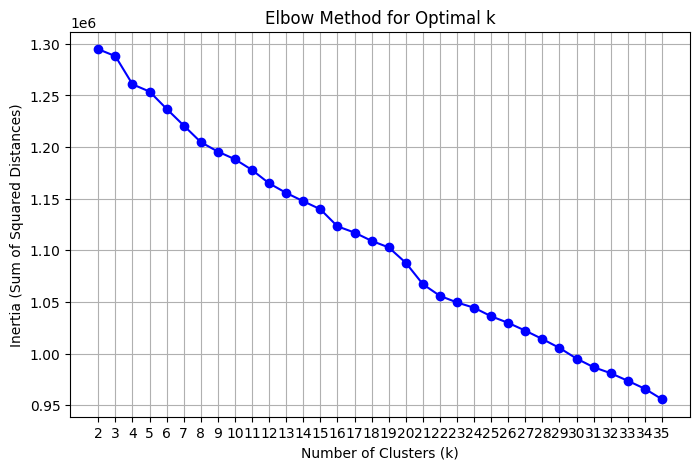

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid()

# Define the output file path
output_file = os.path.join(version_dir, f"k-means_elbow_v{version}.png")

# Save the figure
plt.savefig(output_file, dpi=300, bbox_inches="tight")
print(f"Figure saved as {output_file}")

plt.show()

Save k-means results to the dataframe

In [31]:
# Apply K-Means with the optimal K
print("Applying k means with k = " + str(best_k))
kmeans = KMeans(n_clusters=best_k, random_state=42)
df["KMeans_Cluster"] = kmeans.fit_predict(X)

# Apply K-Means with the forced high k
print("Applying k means with k = " + str(17))
kmeans = KMeans(n_clusters=17, random_state=42)
df["KMeans_Cluster_High"] = kmeans.fit_predict(X)

Applying k means with k = 3
Applying k means with k = 17


Hyperparameter Optimization for DBSCAN

In [44]:
eps_values = np.linspace(0.5, 5.0, 10)
min_samples_values = [2, 3, 5]

best_silhouette = -1
best_eps = None
best_min_samples = None
best_dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore clusters where all points are noise (-1)
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_silhouette:
                best_silhouette = score
                best_eps = eps
                best_min_samples = min_samples
                best_dbscan_labels = labels
                

print(f"Best DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}")

df["DBSCAN_Cluster"] = best_dbscan_labels
number_of_dbscan_clusters = df['DBSCAN_Cluster'].nunique()

Best DBSCAN Parameters: eps=5.0, min_samples=3


Visualizations

t-SNE

Doing t-SNE
Figure saved as ..\Figures\v_3\clustering_results_TSNE_v3.png


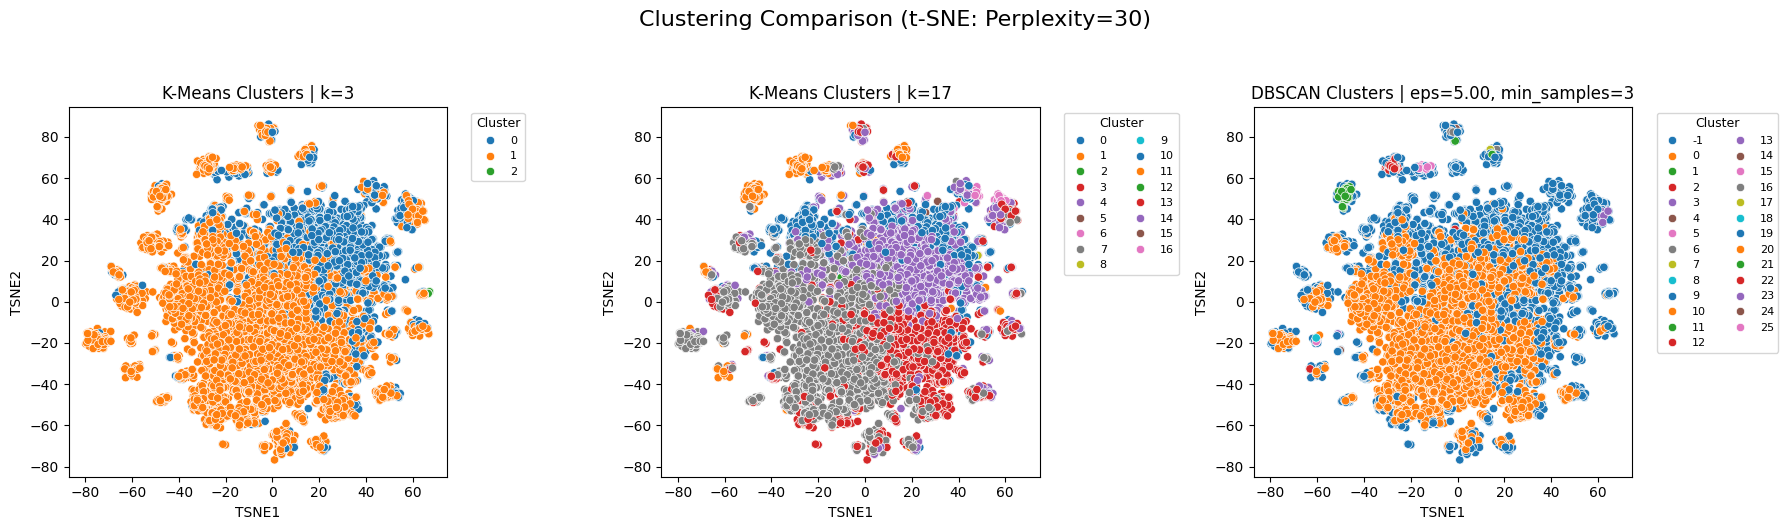

In [53]:
# Reduce to 2D using t-SNE
print("Doing t-SNE")
perplexity = 30
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X_tsne = tsne.fit_transform(X)
df["TSNE1"] = X_tsne[:, 0]
df["TSNE2"] = X_tsne[:, 1]

# Create a figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot K-Means Clusters (Original k)
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="KMeans_Cluster", palette="tab10", ax=axes[0])
axes[0].set_title(f"K-Means Clusters | k={best_k}")
axes[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=9)

# Plot K-Means Clusters (Higher k)
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="KMeans_Cluster_High", palette="tab10", ax=axes[1])
axes[1].set_title("K-Means Clusters | k=17")
axes[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=9, ncol=2)

# Plot DBSCAN Clusters
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="DBSCAN_Cluster", palette="tab10", ax=axes[2])
axes[2].set_title(f"DBSCAN Clusters | eps={best_eps:.2f}, min_samples={best_min_samples}")
axes[2].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=9, ncol=2)

# Add main title
fig.suptitle(f"Clustering Comparison (t-SNE: Perplexity={perplexity})", fontsize=16, y=1.05)
plt.tight_layout()

# Define the output file path
output_file = os.path.join(version_dir, f"clustering_results_TSNE_v{version}.png")

# Save the figure
plt.savefig(output_file, dpi=300, bbox_inches="tight")
print(f"Figure saved as {output_file}")

# Show the figure
plt.show()

UMAP

c:\Users\domen\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


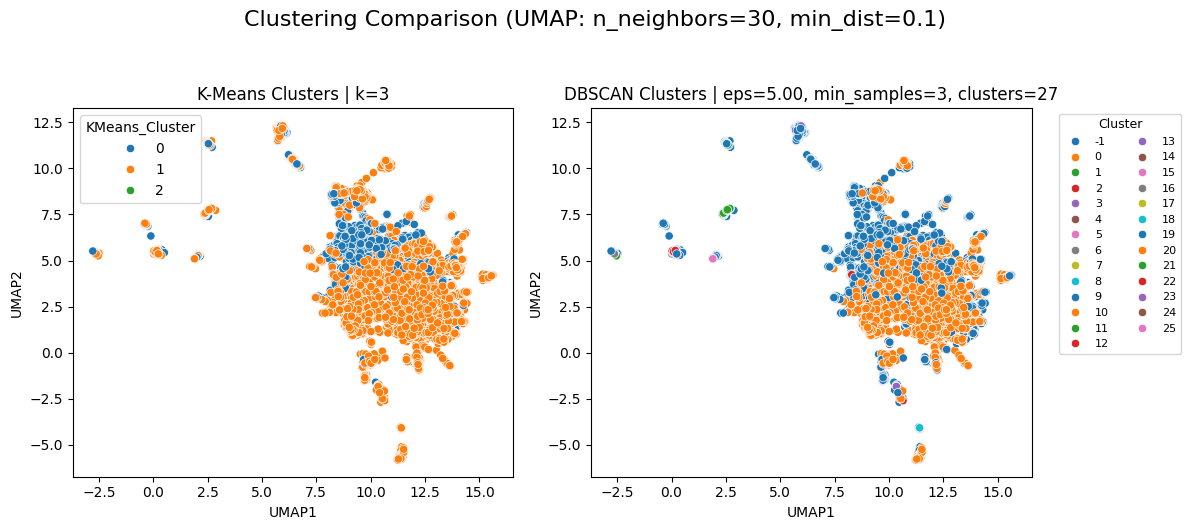

In [ ]:
# Reduce to 2D using UMAP
n_neighbors = 30
min_dist = 0.1
umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
X_umap = umap_reducer.fit_transform(X)
df["UMAP1"] = X_umap[:, 0]
df["UMAP2"] = X_umap[:, 1]

# Plot K-Means Clusters using UMAP
fig = plt.figure(figsize=(12, 5))  # Capture the figure object here
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="KMeans_Cluster", palette="tab10")
plt.title(f"K-Means Clusters | k={best_k}")

# Plot DBSCAN Clusters using UMAP
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="DBSCAN_Cluster", palette="tab10")
plt.title(f"DBSCAN Clusters | eps={best_eps:.2f}, min_samples={best_min_samples}")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=9, ncol=2)

# Add main title with UMAP parameters
fig.suptitle(f"Clustering Comparison (UMAP: n_neighbors={n_neighbors}, min_dist={min_dist})", fontsize=16, y=1.05)
plt.tight_layout()

# Save the UMAP figure
output_file = os.path.join(version_dir, f"clustering_results_umap_v{version}.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")
plt.show()

PCA

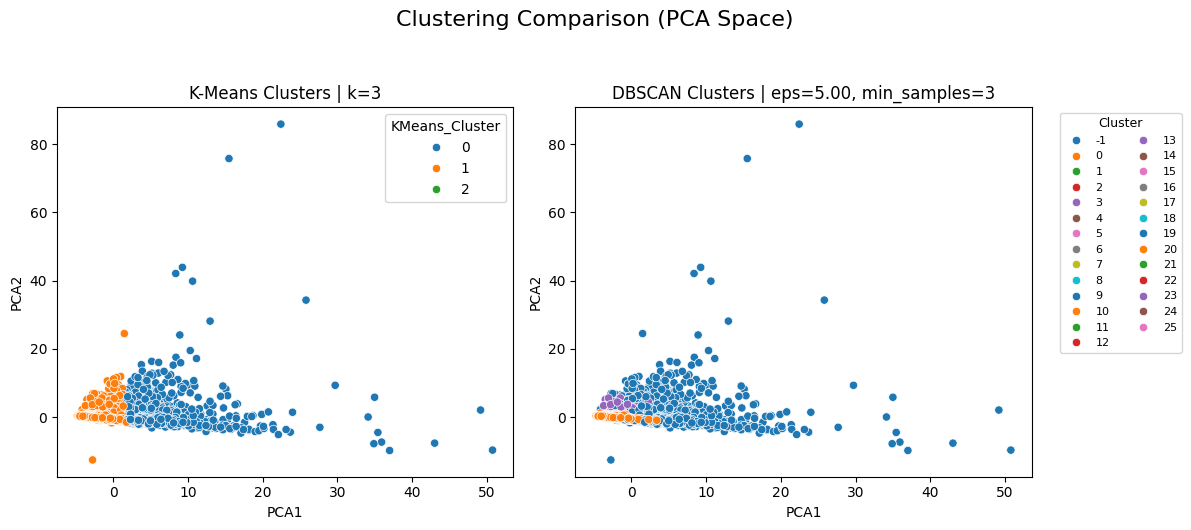

In [52]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# Plot Clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="KMeans_Cluster", palette="tab10", ax=axes[0])
axes[0].set_title(f"K-Means Clusters | k={best_k}")

sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="DBSCAN_Cluster", palette="tab10", ax=axes[1])
axes[1].set_title(f"DBSCAN Clusters | eps={best_eps:.2f}, min_samples={best_min_samples}")
axes[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=9, ncol=2)

# Add main title centered above both subplots
fig.suptitle("Clustering Comparison (PCA Space)", fontsize=16, y=1.05)
plt.tight_layout()

# Save the PCA figure
output_file = os.path.join(version_dir, f"clustering_results_PCA_v{version}.png")
plt.savefig(output_file, dpi=300, bbox_inches="tight")

plt.show()